# Exploratory Data Analysis (EDA) – IBM Telco Customer Churn Dataset

Dieser Report untersucht den IBM Telco Customer Churn Datensatz (7.043 Kunden, 21 Variablen).  
Ziel ist es, erste Einblicke in die Datenstruktur, Verteilungen und mögliche Zusammenhänge zu gewinnen,  
die als Grundlage für die Modellierung der Kundenabwanderung (Churn Prediction) dienen.

## 1. Datenüberblick

- Der Datensatz umfasst **7.043 Kunden** mit **21 Variablen**.  
- Features: 
  - demografisch: `gender`, `SeniorCitizen`, `Partner`, `Dependents`  
  - Vertragsmerkmale: `Contract`, `PaymentMethod`, `PaperlessBilling`  
  - Service-Nutzung: `InternetService`, `StreamingTV`, `TechSupport` usw.  
  - finanzielle Variablen: `MonthlyCharges`, `TotalCharges`, `tenure`  
- Datentypen: 18 kategoriale und 3 numerische Variablen.  
- Fehlende Werte: offiziell **keine**, jedoch ist `TotalCharges` fälschlicherweise als `object` gespeichert. Wird später in `float` konvertiert.  

In [13]:
# Überblick: Shape und erste Zeilen
print(df.shape)
df.head()

# Info über Datentypen
df.info()

# Fehlende Werte
df.isnull().sum()

(7043, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

## **2. Zielvariable (Churn)**

Um die Zielvariable zu verstehen und mögliche methodische Herausforderungen zu identifizieren, wurde zunächst die Verteilung von *Churn* untersucht:

- **Countplot**: Visualisierung der Zielvariable (Churn vs. Non-Churn).  

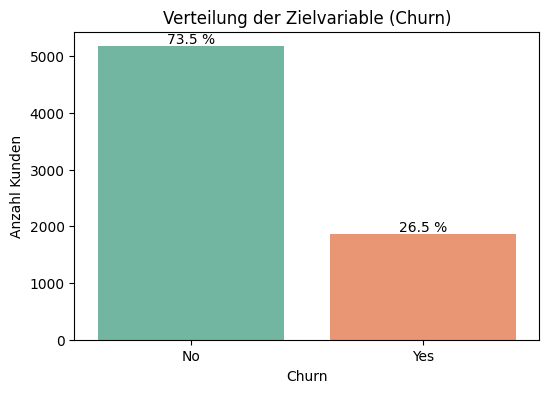

In [15]:
plt.figure(figsize=(6,4))
ax = sns.countplot(x="Churn", hue="Churn", data=df, palette="Set2", legend=False,
                   order=df["Churn"].value_counts().index)
plt.title("Verteilung der Zielvariable (Churn)")
plt.xlabel("Churn")
plt.ylabel("Anzahl Kunden")

# Prozentwerte über die Balken schreiben
total = len(df)
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.,
        height + 50,
        f'{100 * height/total:.1f} %',
        ha="center"
    )

plt.show()

**Interpretation:**  
- Die Zielvariable ist **ungleich verteilt**: Rund **26,5 %** der Kunden haben gekündigt, während **73,5 %** verblieben sind.  
- Dieses Klassenungleichgewicht (Imbalanced Data) hat methodische Implikationen:  
  Modelle könnten dazu neigen, die Mehrheitsklasse (Nicht-Kündiger) zu bevorzugen und dadurch eine scheinbar hohe Genauigkeit zu erzielen.  
- In den nachfolgenden Modellierungsschritten wird das Ungleichgewicht im **Trainingsdatensatz** durch das **SMOTE-Verfahren** adressiert (vgl. Chawla et al., 2002).  

## **3. Demografische Merkmale**

Zur Untersuchung, ob demografische Faktoren mit Kündigungen zusammenhängen, wurden die folgenden Merkmale betrachtet:

- **Gender*: Vergleich der Kündigungsraten zwischen Männern und Frauen.  
- **SeniorCitizen**: Analyse, ob ältere Kunden häufiger kündigen.  
- **Partner / Dependents**: Zusammenhang zwischen familiärer Situation und Kündigung.

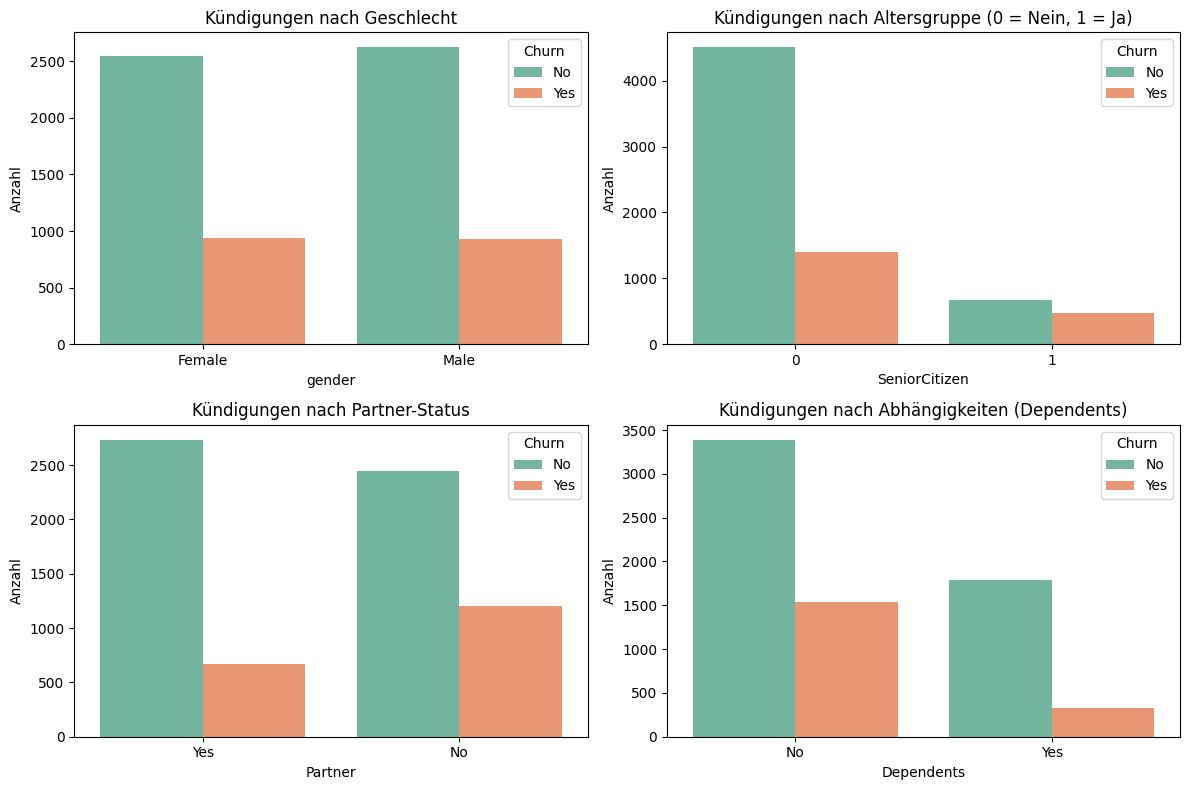

In [23]:
features = ["gender", "SeniorCitizen", "Partner", "Dependents"]
titles = [
    "Kündigungen nach Geschlecht",
    "Kündigungen nach Altersgruppe (0 = Nein, 1 = Ja)",
    "Kündigungen nach Partner-Status",
    "Kündigungen nach Abhängigkeiten (Dependents)"
]

fig, axes = plt.subplots(2, 2, figsize=(12,8))

for ax, feature, title in zip(axes.flatten(), features, titles):
    sns.countplot(x=feature, hue="Churn", data=df, palette="Set2", ax=ax)
    ax.set_title(title)
    ax.set_xlabel(feature)
    ax.set_ylabel("Anzahl")

plt.tight_layout()
plt.show()

**Interpretation:**

- **Gender**: Männer und Frauen kündigen in ähnlichem Verhältnis – kein deutlicher Unterschied.  
- **SeniorCitizen**: Ältere Kunden (SeniorCitizen = 1) zeigen eine deutlich höhere Kündigungsrate als jüngere.  
- **Partner / Dependents**: Kunden ohne Partner oder ohne Abhängige neigen etwas stärker zur Kündigung. 

## **4. Vertrags- und Nutzungsmerkmale**

Um zu prüfen, ob vertragliche Rahmenbedingungen und die Nutzung bestimmter Services Einfluss auf die Kündigungswahrscheinlichkeit haben, wurden die folgenden Merkmale analysiert:

- **Contract Type**: Vergleich der Kündigungsraten zwischen Kunden mit kurzfristigen (Month-to-Month) und längerfristigen Verträgen (One Year, Two Year).  
- **Payment Method**: Analyse, ob die Zahlungsart (z. B. Electronic Check vs. automatische Überweisungen) mit der Kündigungsrate zusammenhängt.  
- **Internet Service**: Untersuchung, ob die Art des Internetanschlusses (DSL, Fiber optic, kein Internet) einen Einfluss auf die Kündigungswahrscheinlichkeit hat.  

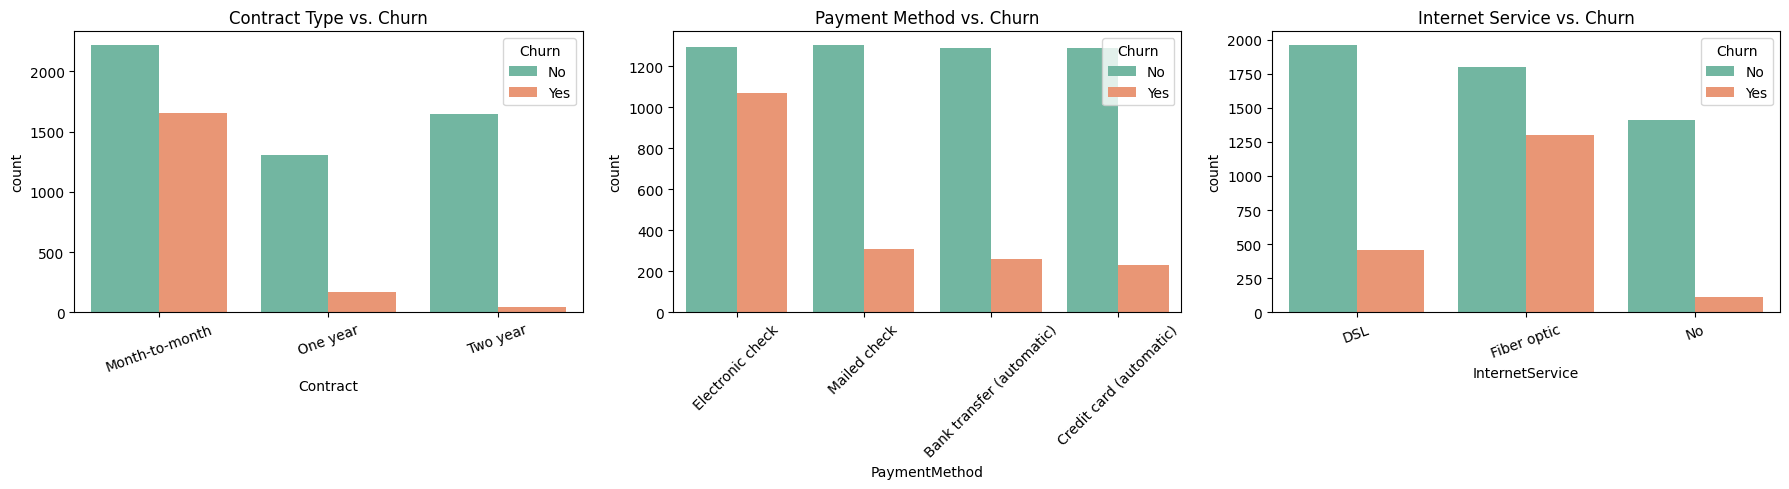

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Contract
sns.countplot(x="Contract", hue="Churn", data=df, ax=axes[0], palette="Set2")
axes[0].set_title("Contract Type vs. Churn")
axes[0].tick_params(axis='x', rotation=20)

# Payment Method
sns.countplot(x="PaymentMethod", hue="Churn", data=df, ax=axes[1], palette="Set2")
axes[1].set_title("Payment Method vs. Churn")
axes[1].tick_params(axis='x', rotation=45)

# Internet Service
sns.countplot(x="InternetService", hue="Churn", data=df, ax=axes[2], palette="Set2")
axes[2].set_title("Internet Service vs. Churn")
axes[2].tick_params(axis='x', rotation=20)

plt.tight_layout()
plt.show()

**Interpretation:**
- **Contract Type**: Kunden mit *Month-to-Month*-Verträgen haben eine deutlich höhere Kündigungsrate als solche mit längeren Vertragslaufzeiten.  
- **Payment Method**: Kunden mit *Electronic Check* kündigen häufiger als Kunden mit automatischen Zahlmethoden.  
- **Internet Service**: Kunden mit *Fiber Optic*-Internet zeigen eine höhere Churn-Rate als DSL- oder Kunden ohne Internetservice.  

## **5. Numerische Variablen**

Um die Verteilung und mögliche Unterschiede zwischen Kündigern und Nicht-Kündigern zu verstehen, wurden folgende Merkmale untersucht:

- **Tenure**: Vertragsdauer in Monaten  
- **MonthlyCharges**: Monatliche Gebühren  
- **TotalCharges**: Gesamtkosten über die Vertragsdauer  

Neben Histogrammen zur Verteilung werden Boxplots nach Churn-Status gezeigt, um potenzielle Ausreißer und Unterschiede zwischen den Gruppen zu identifizieren. Zusätzlich werden zentrale Kennzahlen (Mittelwert, Median, Standardabweichung) berechnet.

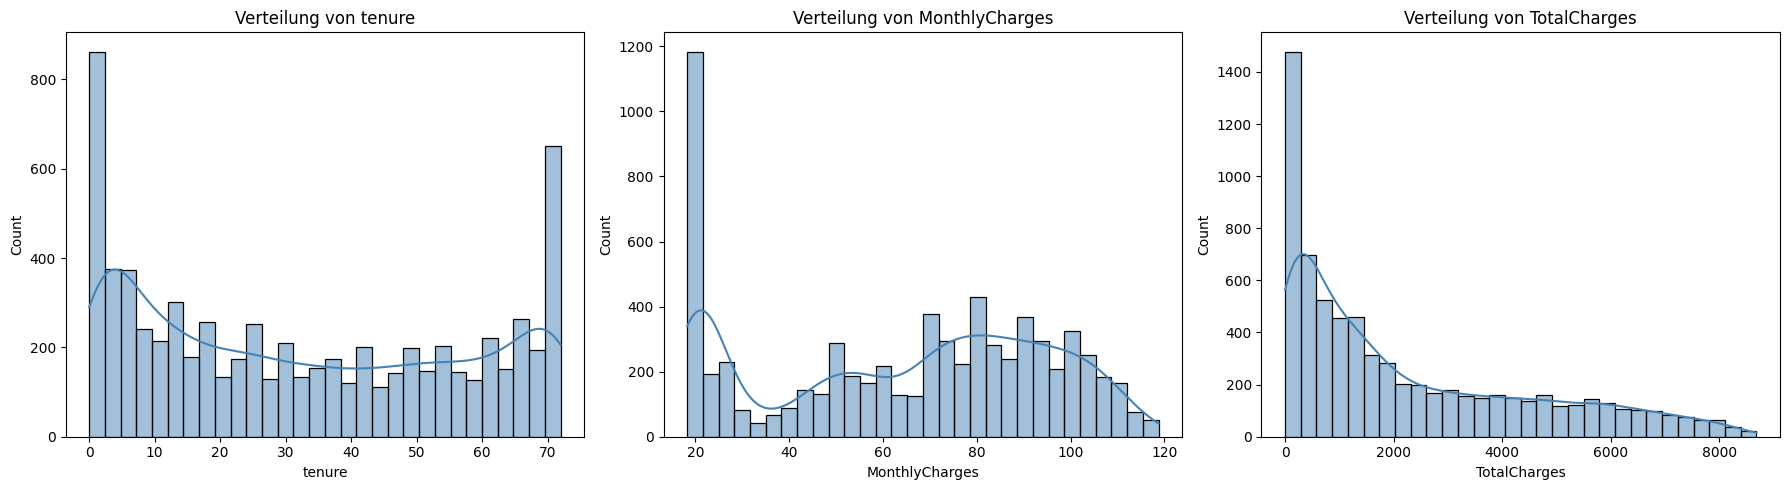

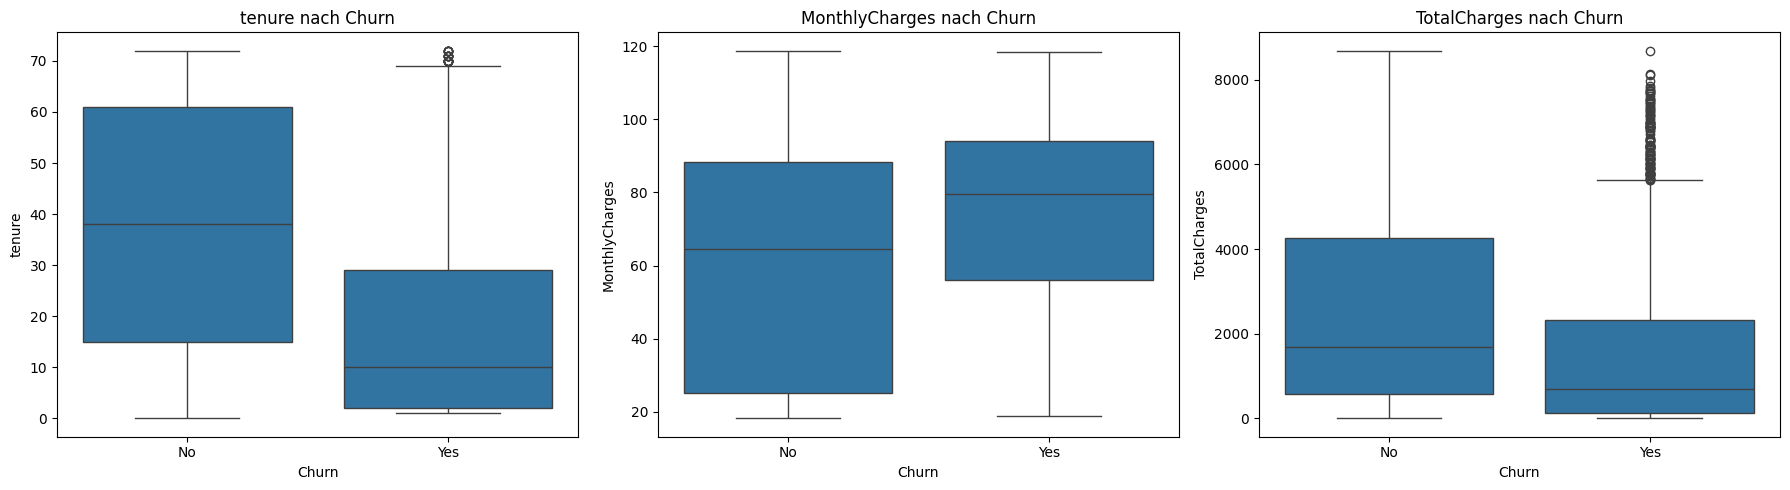

,count,mean,std,min,25%,50%,75%,max,median
tenure,7043.0,32.371149,24.559481,0.00,9.00,29.00,55.00,72.00,29.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.50,70.35,89.85,118.75,70.35
TotalCharges,7043.0,2279.734304,2266.794470,0.00,398.55,1394.55,3786.60,8684.80,1394.55


In [29]:
# --- TotalCharges konvertieren ---
df = df.assign(
    TotalCharges=pd.to_numeric(df["TotalCharges"], errors="coerce")
)
df["TotalCharges"] = df["TotalCharges"].fillna(0)

# Relevante numerische Features
num_features = ["tenure", "MonthlyCharges", "TotalCharges"]

import matplotlib.pyplot as plt
import seaborn as sns

# --- Histogramme ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, feature in zip(axes, num_features):
    sns.histplot(df[feature], bins=30, kde=True, ax=ax, color="steelblue")
    ax.set_title(f"Verteilung von {feature}")
plt.tight_layout()
plt.show()

# --- Boxplots nach Churn (Ausreißerprüfung) ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, feature in zip(axes, num_features):
    sns.boxplot(
        x="Churn", y=feature, data=df,
        ax=ax
    )
    ax.set_title(f"{feature} nach Churn")
plt.tight_layout()
plt.show()

# --- Kennzahlen ---
stats = df[num_features].describe().T
stats["median"] = df[num_features].median()
display(stats)

**Interpretation:**  
- **Tenure**: Kunden mit kurzer Vertragsdauer (vor allem < 12 Monate) kündigen deutlich häufiger, während Langzeitkunden (60+ Monate) sehr selten kündigen.  
- **MonthlyCharges**: Kunden mit hohen monatlichen Gebühren (> 80 USD) zeigen eine erhöhte Kündigungsrate im Vergleich zu Kunden mit niedrigeren Gebühren.  
- **TotalCharges**: Kündigende Kunden weisen meist geringere Gesamtausgaben auf, da sie den Vertrag frühzeitig beendet haben und dadurch weniger Zahlungen geleistet haben.  

## **6. Korrelationen**

Um Zusammenhänge zwischen den Variablen und der Zielgröße **Churn** zu untersuchen, wurde eine Korrelationsmatrix erstellt und als Heatmap visualisiert.  
Dazu wurden kategoriale Merkmale kodiert (z. B. Contract, PaymentMethod, InternetService), sodass numerische Korrelationen berechnet werden konnten.  

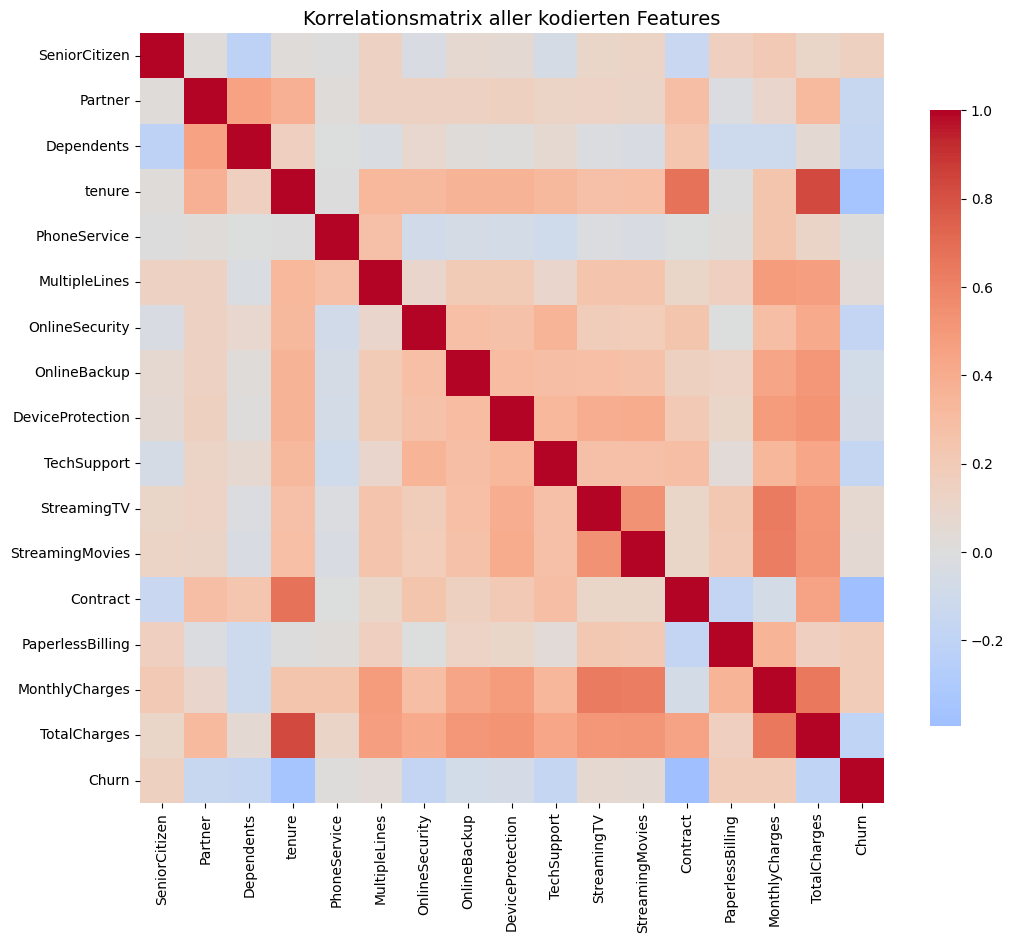

Top positive Korrelationen mit Churn:


Churn               1.000000
MonthlyCharges      0.193356
PaperlessBilling    0.191825
SeniorCitizen       0.150889
StreamingTV         0.063228
StreamingMovies     0.061382
MultipleLines       0.040102
PhoneService        0.011942
DeviceProtection   -0.066160
OnlineBackup       -0.082255
Name: Churn, dtype: float64

Top negative Korrelationen mit Churn:


PhoneService        0.011942
DeviceProtection   -0.066160
OnlineBackup       -0.082255
Partner            -0.150448
Dependents         -0.164221
TechSupport        -0.164674
OnlineSecurity     -0.171226
TotalCharges       -0.198324
tenure             -0.352229
Contract           -0.394453
Name: Churn, dtype: float64

In [33]:
df_corr = df.copy()

# Churn als 0/1 kodieren
df_corr["Churn"] = df_corr["Churn"].map({"Yes": 1, "No": 0})

# SeniorCitizen ist schon numerisch
# Partner/Dependents/PhoneService → sauber mappen
binary_map = {"Yes": 1, "No": 0}
for col in ["Partner", "Dependents", "PhoneService", "PaperlessBilling"]:
    df_corr[col] = df_corr[col].map(binary_map)

# MultipleLines & Internet-bezogene Variablen haben "No phone service"/"No internet service"
special_cols = ["MultipleLines", "OnlineSecurity", "OnlineBackup", "DeviceProtection",
                "TechSupport", "StreamingTV", "StreamingMovies"]
for col in special_cols:
    df_corr[col] = df_corr[col].replace(
        {"No phone service": "No", "No internet service": "No"}
    ).map(binary_map)

# Contract ordinal kodieren
contract_map = {"Month-to-month": 1, "One year": 12, "Two year": 24}
df_corr["Contract"] = df_corr["Contract"].map(contract_map)

# PaymentMethod & InternetService als Dummies
df_corr = pd.get_dummies(df_corr, columns=["PaymentMethod", "InternetService"], drop_first=True)

# TotalCharges sicherstellen → float
df_corr["TotalCharges"] = pd.to_numeric(df_corr["TotalCharges"], errors="coerce").fillna(0)

# --- Nur numerische Spalten ---
import numpy as np
df_corr_num = df_corr.select_dtypes(include=[np.number])

# --- Korrelationen ---
corr_matrix = df_corr_num.corr()

# Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=False, cbar_kws={"shrink": .8})
plt.title("Korrelationsmatrix aller kodierten Features", fontsize=14)
plt.show()

# Top-Korrelationen mit Churn
churn_corr = corr_matrix["Churn"].sort_values(ascending=False)
print("Top positive Korrelationen mit Churn:")
display(churn_corr.head(10))
print("Top negative Korrelationen mit Churn:")
display(churn_corr.tail(10))

**Interpretation:**  
- **Positive Korrelationen mit Churn**:  
  - Höhere **monatliche Gebühren (MonthlyCharges)** und **papierlose Abrechnung (PaperlessBilling)** stehen in Zusammenhang mit einer leicht höheren Kündigungsrate.  
  - Auch **Senior Citizens** zeigen eine erhöhte Kündigungswahrscheinlichkeit.  

- **Negative Korrelationen mit Churn**:  
  - **Längere Vertragslaufzeiten (Contract)** und eine hohe **Kundendauer (tenure)** wirken stark churn-reduzierend.  
  - Zusatzservices wie **OnlineSecurity** oder **TechSupport** reduzieren ebenfalls die Kündigungswahrscheinlichkeit.  
  - **Familiäre Bindungen** (Partner, Dependents) gehen mit geringerer Churn-Rate einher.

## **7. Erste Hypothesen & Implikationen**

Auf Basis der explorativen Analysen lassen sich folgende Hypothesen formulieren:  

- **Kurzfristige Verträge (Month-to-Month)** sind ein zentraler Risikofaktor für Churn, während längere Vertragslaufzeiten stark bindend wirken.  
- **Hohe monatliche Gebühren** erhöhen die Kündigungswahrscheinlichkeit, insbesondere in Kombination mit kurzen Vertragslaufzeiten.  
- **Zusatzservices** wie OnlineSecurity oder TechSupport tragen zur Kundenbindung bei und reduzieren die Churn-Rate.  
- **Demografische Merkmale** (z. B. SeniorCitizen) zeigen einen Einfluss, während **Geschlecht** keine klare Trennung erkennen lässt.  
- **Familiäre Bindungen** (Partner, Dependents) wirken churn-reduzierend.  

**Implikationen für die Modellierung:**  
- Modelle sollten besonders auf **Vertragsart, Gebührenstruktur und Zusatzservices** achten.  
- Aufgrund der **Klassenungleichverteilung (≈ 26,5 % Churn)** ist es notwendig, das Ungleichgewicht im Training zu adressieren.  